<a href="https://colab.research.google.com/github/Bokocki/135UM-Homework/blob/main/Homework12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Is a *queen* really just a *king*, minus a *man*, plus a *woman*?**

--------------



In class, we dealt with **embeddings** trained for **sentiment classification**. These embeddings are optimized to separate *positive* from *negative* expressions and **do not encode deeper semantic information**.

However, in modern natural language processing, there exist other embeddings — such as those from **BERT**, **word2vec**, or **GloVe** — that **do capture semantic structure**. These models are trained on large corpora, and their embeddings often allow for meaningful **vector arithmetic**, like the famous:

```
embedding("king") - embedding("man") + embedding("woman") ≈ embedding("queen")
```

This homework explores **semantic vector relationships** using such pretrained embeddings.

## **The Objective**

Your task is to:

1. Construct semantic classes of word pairs.
2. Visualize them using PCA.
3. Explore arithmetic operations in embedding space.

## **Tasks & Deliverables**

### 1. **Semantic Pair Classes**

- You must gather **at least 10 classes** of semantically related word pairs.
- Each class must contain **at least 5 pairs**.
- That gives a **minimum total of 100 unique words** (10 classes x 5 pairs x 2 words per pair).

Two example classes:

**Class 1: Gender**

- (king, queen)
- (man, woman)
- (doctor, nurse)
- (prince, princess)
- *(you must add one more)*

**Class 2: Verb tense (past tense)**

- (bring, brought)
- (get, got)
- (like, liked)
- *(you must add two more)*

**Your job:**

- Invent or search for **at least 10 such classes**, including the examples above.
- Each class must be conceptually coherent.
- Other examples: singular/plural, country/capital, comparative/superlative, tool/user, job/object, etc.

### 2. **Global PCA (Across All Words)**

- Use PCA to reduce the **entire set of 100 word embeddings** to 2D, and plot it.
- Plot the additional **10 separate charts**, one for each class.
  - Each chart should display only the 10 words (5 pairs) of the given class.
- Points should be labeled with the words themselves.

### 3. **Local PCA (Per Class)**

- For each class (10 total), perform PCA **only** on the 10 words of that class.
- Plot these class-wise PCA visualizations as separate charts.
- Again, points should be labeled with the words.

**Total: 21 charts**
(1 global plot with 100 words + 10 global-space class plots + 10 local PCA class plots)

Charts should be presented in a self-explanatory manner with clear labels.

### 4. **Embedding Arithmetic**

For each class, choose **one example pair** (e.g., (king, queen)) and perform the operation:

```
embedding(B) - embedding(A) + embedding(C)
```

Where A and B form a known pair, and C is another base word.
For example:

```
embedding("king") - embedding("man") + embedding("woman")
```

* For each such result vector, find the **5 closest word embeddings** (using cosine similarity or Euclidean distance).
* Print the top 5 neighbors **with their distances**.
* Do this **once per class** (i.e., 10 times).

This will make it possible to verify if
 ```
embedding("queen") ≈ embedding("king") - embedding("man") + embedding("woman")
```
for the *gender*-related class.


### 5. **Discussion**

* Analyze and interpret your 21 plots.
* Discuss whether the vector relationships are preserved.
* Does PCA capture semantic differences?
* Are the closest words from the arithmetic meaningful?
* What kinds of relationships are captured, and what are not?
* Are some classes better behaved than others?


### 6. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.


## Acknowledgments

*This homework assignment was inspired by an idea from my master's student **Andrzej Małek**, to whom I would like to express my thanks.*

# Solution to the homework
---
## Setting up the pretrained embedding (GloVe)

In [1]:
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# ----------------- Load GloVe ------------------------

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = torch.tensor([float(x) for x in parts[1:]], dtype=torch.float)
            embeddings[word] = vec
    return embeddings

# link to the text file with the embedding, because it is too large to put into GitHub (about 1 GB)
# https://drive.google.com/file/d/13c3gB4FyB6JP3bjvWE06BpJZy7wedRu3/view?usp=sharing
glove_path = "glove.6B.300d.txt"
glove = load_glove_embeddings(glove_path)

## Defining the semantic classes

In [2]:
# ----------------- Define Semantic Classes ------------------------

semantic_classes = {
    'Gender': [
        ('man', 'woman'),
        ('king', 'queen'),
        ('boy', 'girl'),
        ('prince', 'princess'),
        ('waiter', 'waitress'),
    ],
    'Verb Tense (Past)': [
        ('bring', 'brought'),
        ('get', 'got'),
        ('like', 'liked'),
        ('run', 'ran'),
        ('write', 'wrote'),
    ],
    'Singular/Plural': [
        ('cat', 'cats'),
        ('foot', 'feet'),
        ('child', 'children'),
        ('car', 'cars'),
        ('man', 'men'),
    ],
    'Comparative': [
        ('big', 'bigger'),
        ('small', 'smaller'),
        ('fast', 'faster'),
        ('slow', 'slower'),
        ('strong', 'stronger'),
    ],
    'Synonyms': [
        ('big', 'large'),
        ('angry', 'furious'),
        ('sad', 'unhappy'),
        ('happy', 'delighted'),
        ('strong', 'powerful'),
    ],
    'Country/Capital': [
        ('france', 'paris'),
        ('germany', 'berlin'),
        ('italy', 'rome'),
        ('spain', 'madrid'),
        ('japan', 'tokyo'),
    ],
    'Currency': [
        ('usa', 'dollar'),
        ('europe', 'euro'),
        ('japan', 'yen'),
        ('uk', 'pound'),
        ('india', 'rupee'),
    ],
    'Tool/User': [
        ('pen', 'writer'),
        ('brush', 'painter'),
        ('scalpel', 'surgeon'),
        ('microscope', 'scientist'),
        ('gavel', 'judge'),
    ],
    'Job/Object': [
        ('carpenter', 'wood'),
        ('chef', 'food'),
        ('painter', 'paint'),
        ('teacher', 'book'),
        ('mechanic', 'engine'),
    ],
    'Opposites': [
        ('hot', 'cold'),
        ('light', 'dark'),
        ('happy', 'sad'),
        ('fast', 'slow'),
        ('young', 'old'),
    ]
}

## Plot global PCA

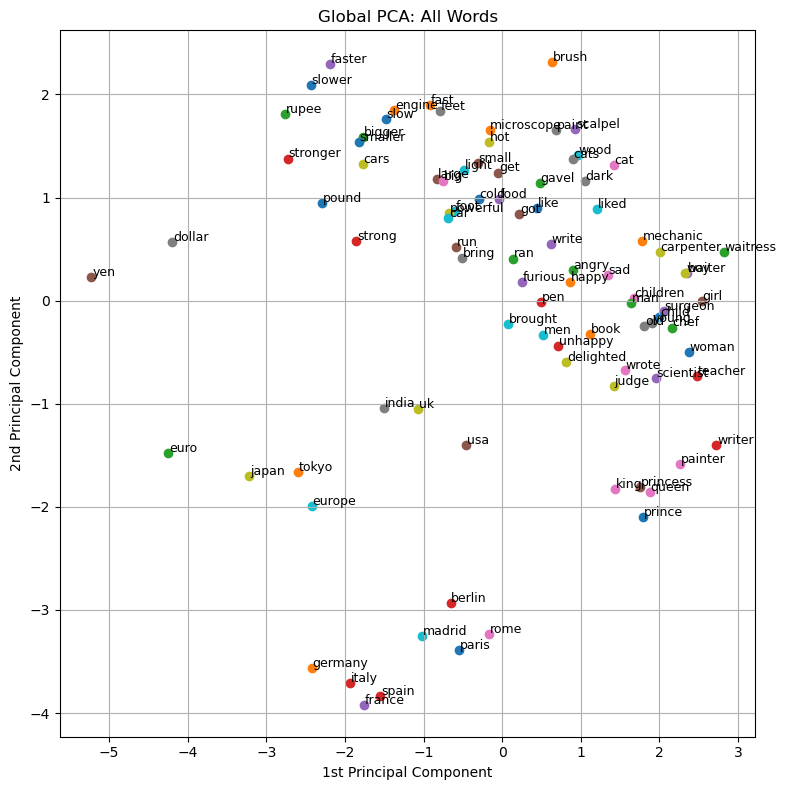

In [3]:
# ----------------- Prepare Word Embeddings ------------------------

unique_words = list(set(word for pairs in semantic_classes.values() for pair in pairs for word in pair))
missing = [word for word in unique_words if word not in glove]
if missing:
    print("Missing from GloVe:", missing)

embeddings = {word: glove[word] for word in unique_words}

glove_words = list(glove.keys())
glove_matrix = torch.stack([glove[word] for word in glove_words])

# ----------------- Plotting ------------------------

def plot_side_by_side_pca(words, title):
    vecs = torch.stack([embeddings[w] for w in words])

    # Global PCA
    global_pca = PCA(n_components=2)
    all_vecs = torch.stack([embeddings[w] for w in unique_words])
    global_reduced = global_pca.fit(all_vecs).transform(vecs)

    # Local PCA
    local_pca = PCA(n_components=2)
    local_reduced = local_pca.fit_transform(vecs)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(title, fontsize=14)

    for ax, reduced, label in zip(
        axs, [global_reduced, local_reduced], ["Global PCA", "Local PCA"]
    ):
        ax.set_title(label)
        for i, word in enumerate(words):
            x, y = reduced[i]
            ax.scatter(x, y)
            ax.text(x + 0.01, y + 0.01, word, fontsize=9)
        ax.set_xlabel("1st Principal Component")
        ax.set_ylabel("2nd Principal Component")
        ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ----------------- Plot Global Classes ------------------------

# Global PCA: all words
def plot_global_all():
    vecs = torch.stack([embeddings[w] for w in unique_words])
    reduced = PCA(n_components=2).fit_transform(vecs)

    plt.figure(figsize=(8, 8))
    plt.title("Global PCA: All Words")
    for i, word in enumerate(unique_words):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, word, fontsize=9)
    plt.xlabel("1st Principal Component")
    plt.ylabel("2nd Principal Component")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_global_all()

Given the diversity of the 100 words drawn from various semantic classes, it’s unsurprising that the global PCA plot does not exhibit a perfectly clean structure. However, some patterns do emerge. For instance, we can observe a loose clustering of geographical entities, like countries and capitals, near the center and lower regions of the plot. Meanwhile, terms related to people, such as professions and gendered nouns, tend to gather on the right side. While PCA reduces high-dimensional data to just two dimensions (and inevitably loses information in the process), it still manages to reflect some semantic separations. This suggests that even with linear dimensionality reduction, the embeddings preserve a degree of meaningful structure. That said, the overlap between unrelated semantic classes and the absence of clear boundaries between many seemingly unrelated categories confirm that PCA alone is not sufficient to capture finer semantic structures.

## Comparing global PCA to local PCA

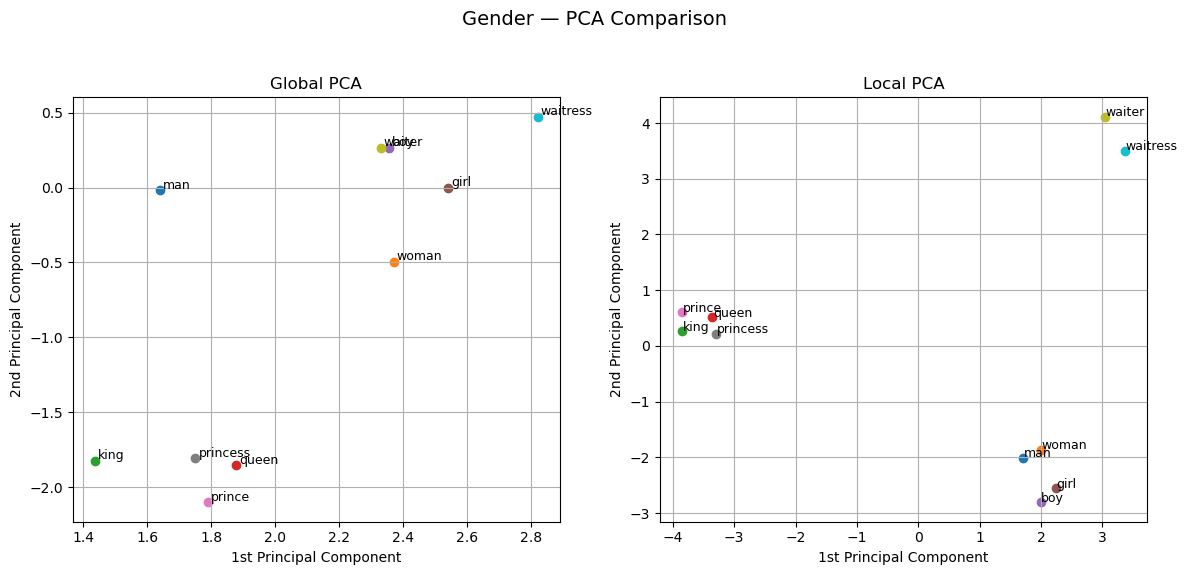

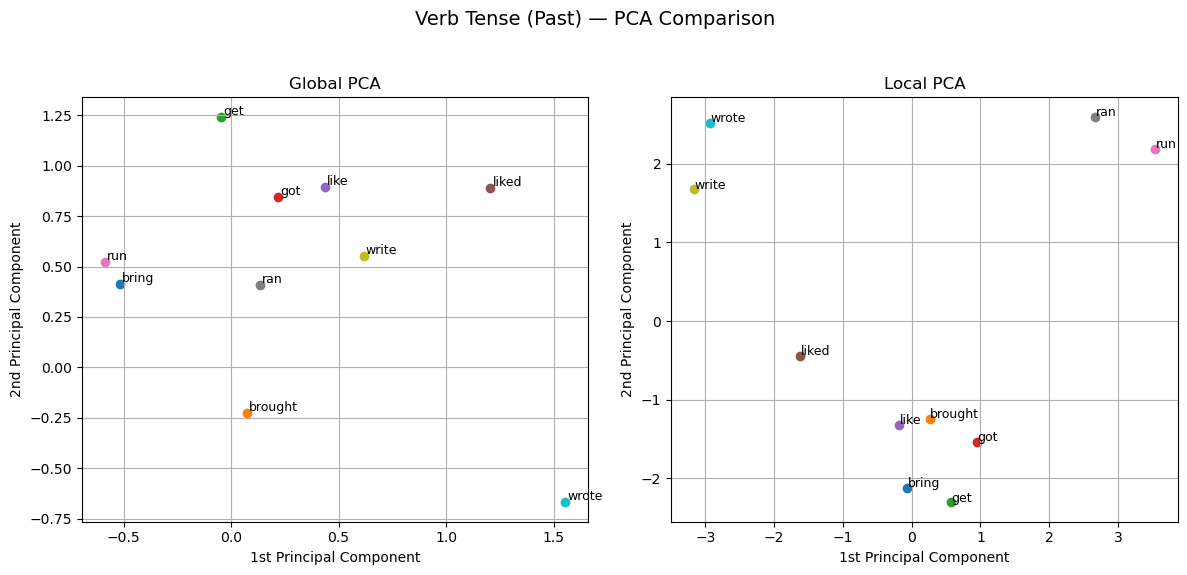

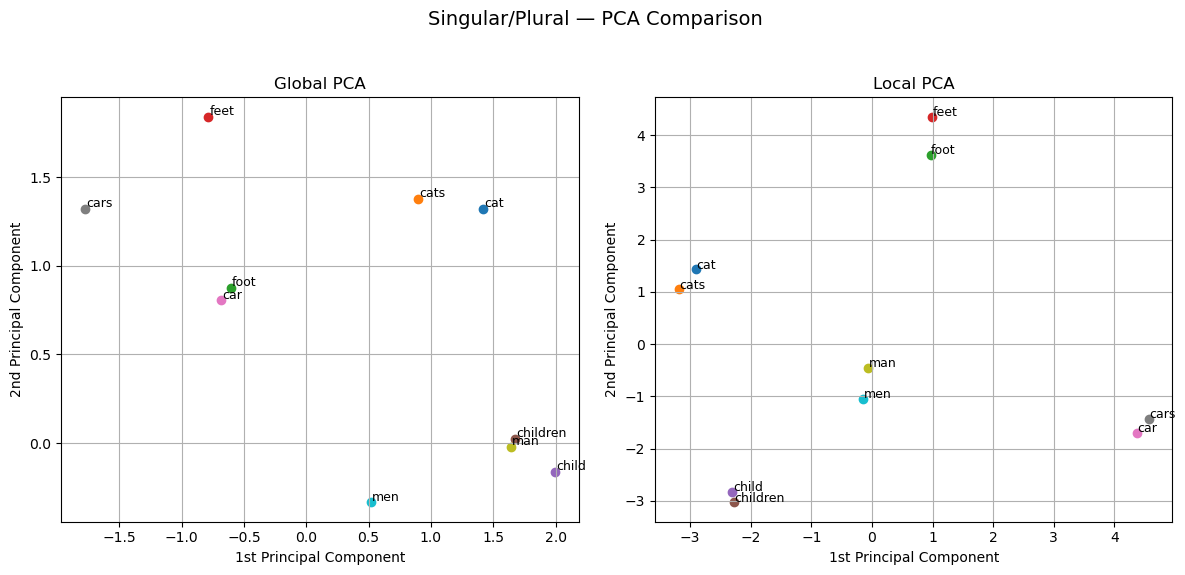

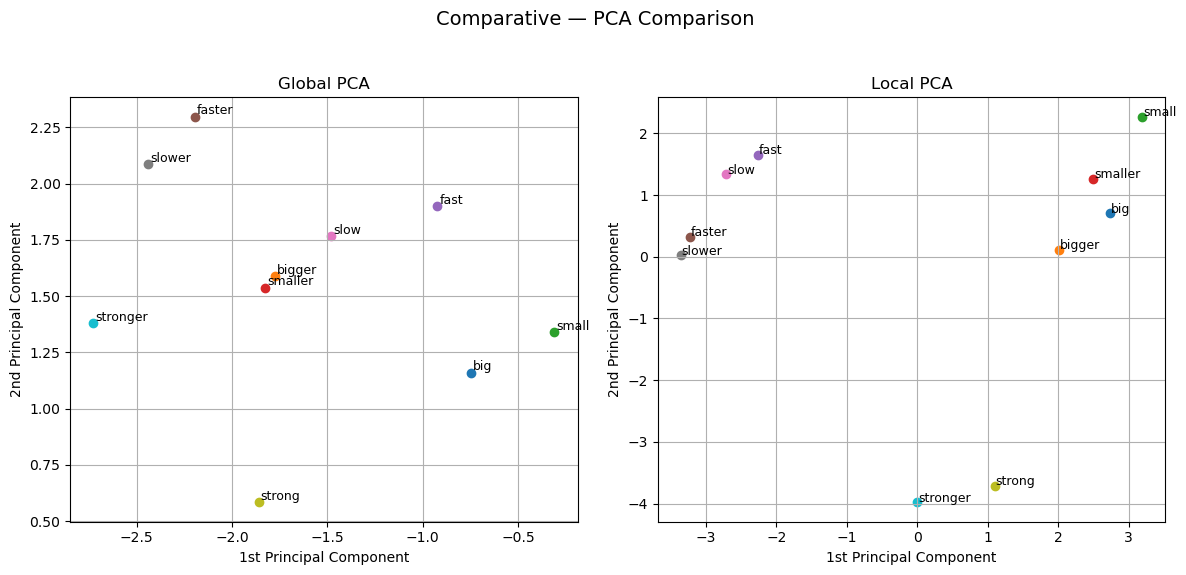

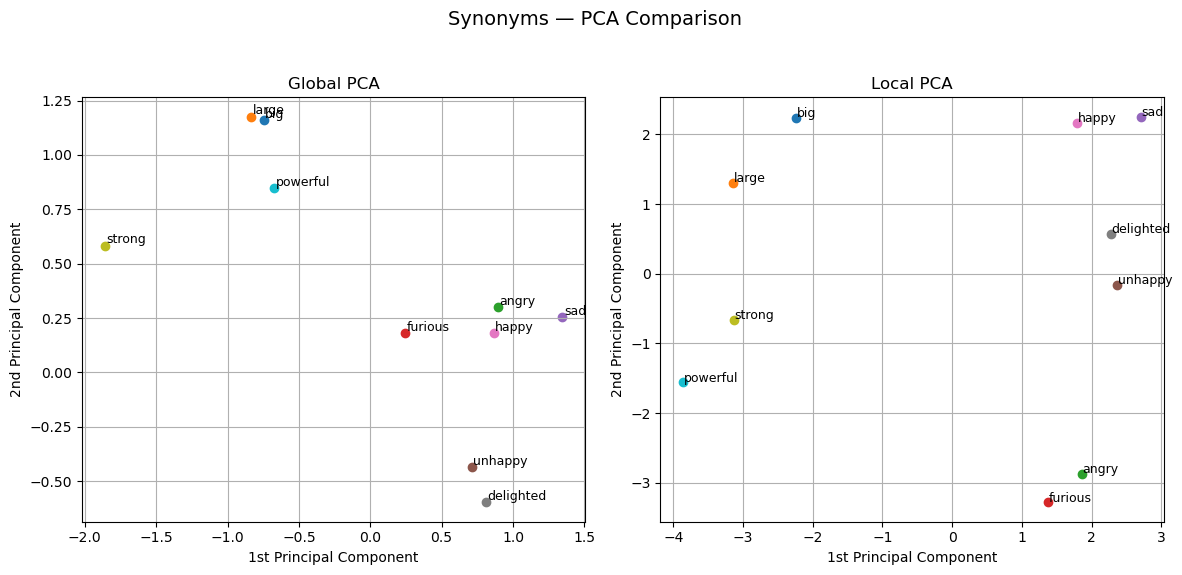

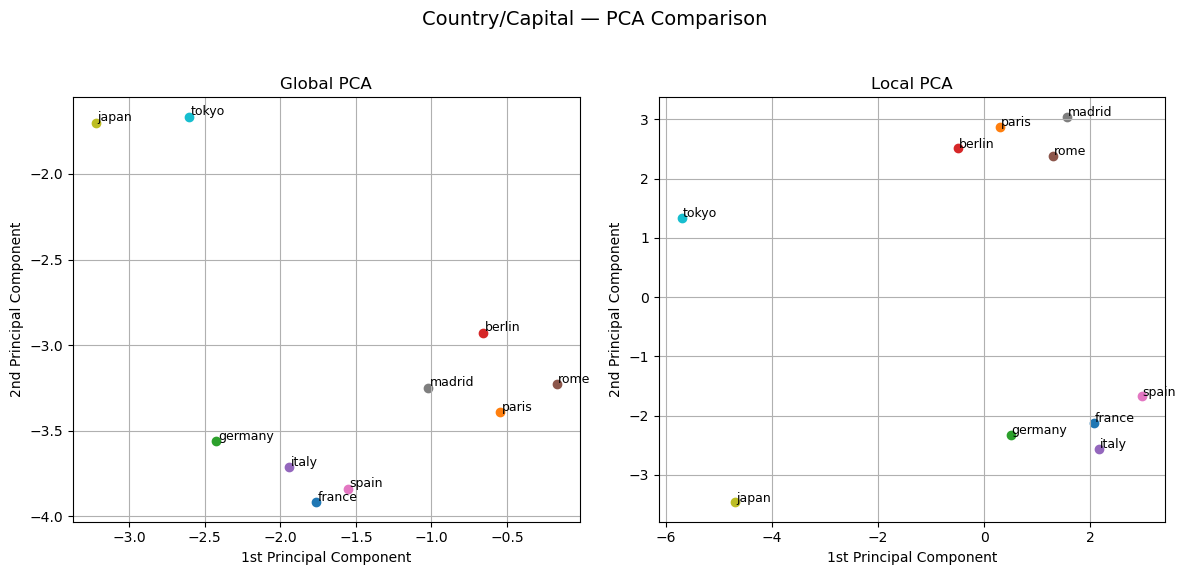

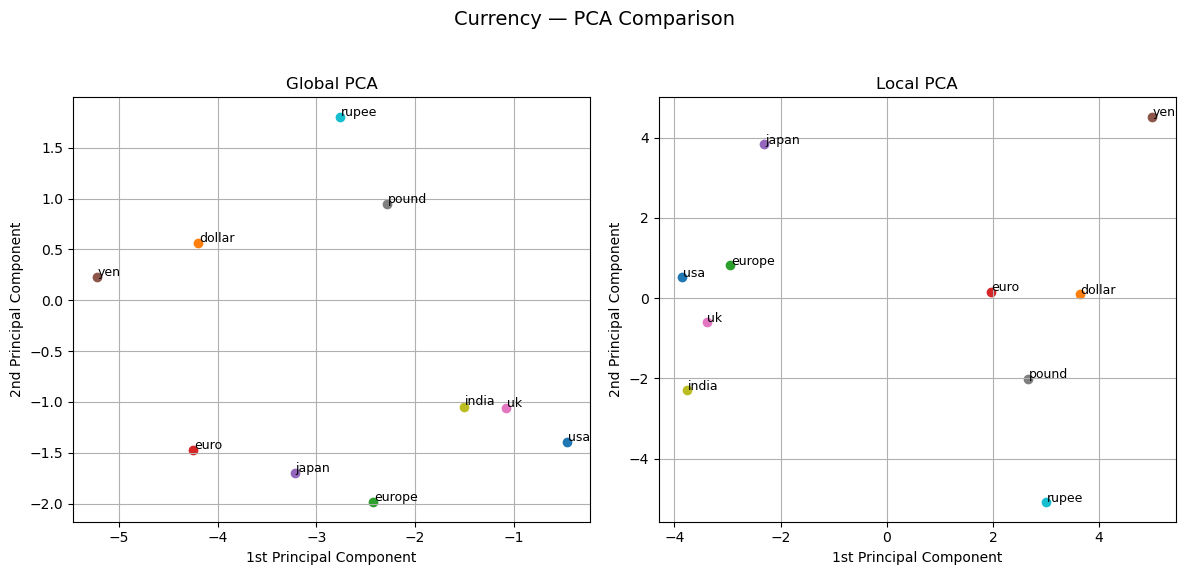

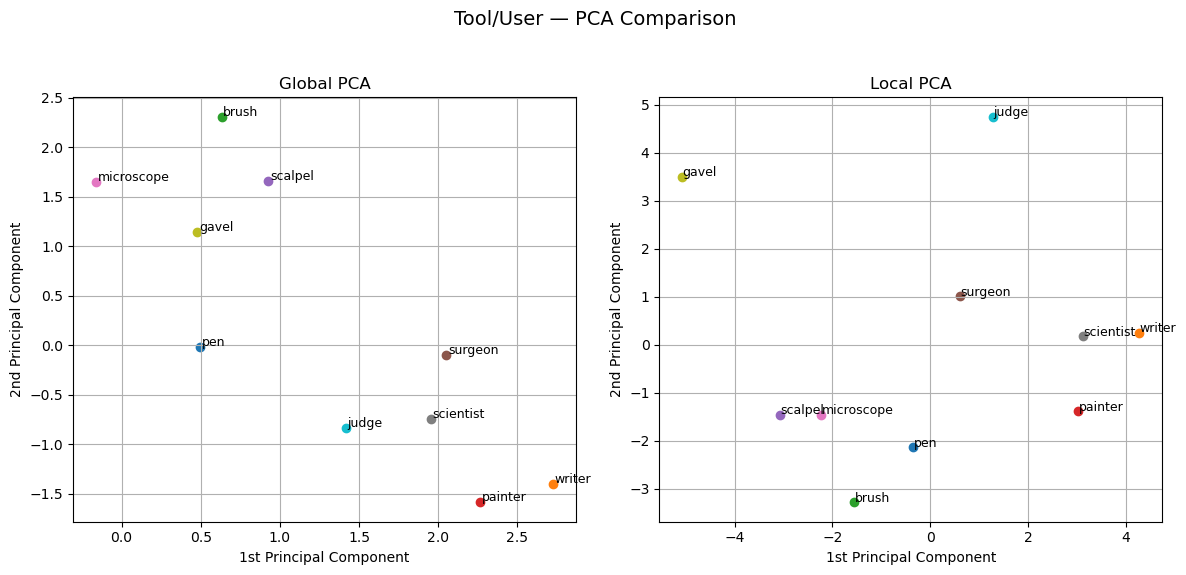

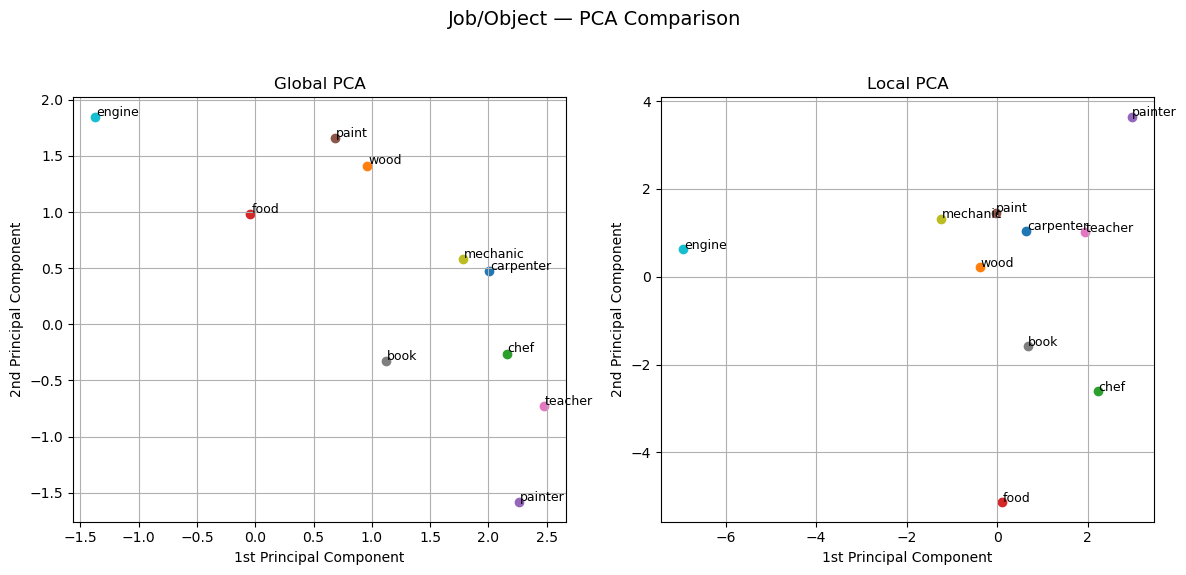

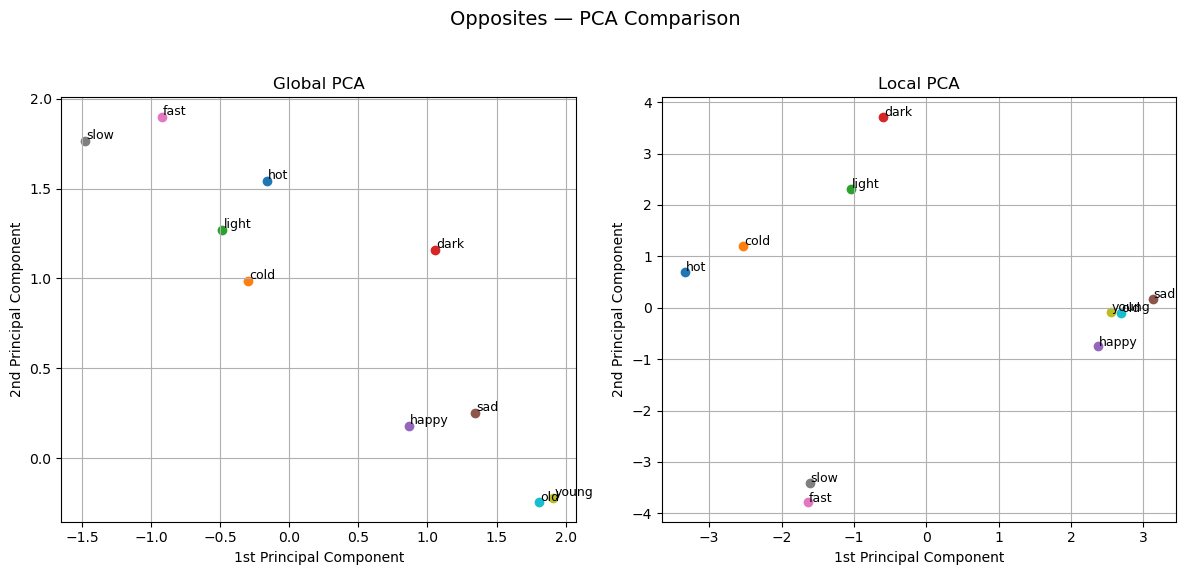

In [4]:
# ----------------- Plot All Classes ------------------------

for class_name, pairs in semantic_classes.items():
    words = [w for pair in pairs for w in pair]
    plot_side_by_side_pca(words, f"{class_name} — PCA Comparison")

Comparing side by side PCA plots for all 100 words and one restricted to each semantic class reveals interesting patterns. The effectiveness of local PCA varies by class, but in several cases, the improvement is dramatic. For instance, in the "Gender", "Verb Tense (Past)", "Singular/Plural", "Comparative", and "Synonyms" classes, local PCA clearly outperforms the global version. It clusters related word pairs closely and keeps different pairs meaningfully apart, something the global PCA struggles with due to interference from unrelated words.

However, this effect isn’t universal. In classes like "Country/Capital", "Currency", "Job/Object", and "Tool/User", both PCA methods perform similarly, often producing a clear separation between subcategories (e.g., capitals vs. countries). For the "Opposites" class, both local and global PCA appear equally capable of revealing the semantic pattern.

Broadly speaking, local PCA often enhances interpretability when the class structure is strong and well-represented in the embedding space. This makes intuitive sense: by narrowing the vocabulary to a tightly defined semantic category, we reduce noise and give PCA a better chance at highlighting the structure. If the embeddings capture the semantic distinctions to begin with, local PCA simply makes that structure more visible.

## Embedding Arithmetic

In [5]:
# ----------------- Embedding Arithmetic ------------------------

def find_closest(vec, metric='cosine', k=5):
    if metric == 'cosine':
        scores = F.cosine_similarity(vec.unsqueeze(0), glove_matrix)
    elif metric == 'euclidean':
        scores = -torch.norm(glove_matrix - vec.unsqueeze(0), dim=1)
    else:
        raise ValueError("Unknown metric")

    topk = torch.topk(scores, k + 20)
    result = []
    for idx in topk.indices:
        word = glove_words[idx]
        if word not in embeddings:
            score = scores[idx].item()
            result.append((word, score))
        if len(result) == k:
            break
    return result

print("\n=== Embedding Arithmetic Results ===\n")

for class_name, pairs in semantic_classes.items():
    A, B = pairs[0]
    C = pairs[1][0]

    try:
        result_vec = embeddings[C] - embeddings[A] + embeddings[B]

        print(f"{class_name}:")
        print(f"  {C} - {A} + {B} ≈ ?")

        cos_top = find_closest(result_vec, metric='cosine', k=5)
        print("    Top 5 by Cosine Similarity:")
        for word, score in cos_top:
            print(f"      {word:15} (cos sim: {score:.4f})")

        eucl_top = find_closest(result_vec, metric='euclidean', k=5)
        print("    Top 5 by Euclidean Distance:")
        for word, score in eucl_top:
            print(f"      {word:15} (eucl dist ~ {-score:.4f})")

        print()

    except KeyError as e:
        print(f"  Skipped due to missing word: {e}")


=== Embedding Arithmetic Results ===

Gender:
  king - man + woman ≈ ?
    Top 5 by Cosine Similarity:
      monarch         (cos sim: 0.5575)
      throne          (cos sim: 0.5565)
      mother          (cos sim: 0.5142)
      daughter        (cos sim: 0.5133)
      kingdom         (cos sim: 0.5025)
    Top 5 by Euclidean Distance:
      monarch         (eucl dist ~ 6.8999)
      mother          (eucl dist ~ 7.1786)
      daughter        (eucl dist ~ 7.2773)
      elizabeth       (eucl dist ~ 7.2946)
      throne          (eucl dist ~ 7.2948)

Verb Tense (Past):
  get - bring + brought ≈ ?
    Top 5 by Cosine Similarity:
      getting         (cos sim: 0.7720)
      when            (cos sim: 0.6866)
      gotten          (cos sim: 0.6636)
      gets            (cos sim: 0.6476)
      so              (cos sim: 0.6471)
    Top 5 by Euclidean Distance:
      getting         (eucl dist ~ 3.8927)
      when            (eucl dist ~ 4.4044)
      so              (eucl dist ~ 4.6667)
      

Unfortunately, our embedding failed the *queen* = *king* – *man* + *woman* analogy. That said, it still manages to capture some meaningful semantic structure. In the "Gender" class, for example, while it didn’t land on *queen*, it did rank *mother* and *daughter* highly, both feminine terms, alongside conceptually related words like *monarch*, *throne*, and *kingdom*. So while not precise, the direction is definitely semantically motivated.

In the "Verb Tense (Past)" class, the results are mixed. The model identified *gotten*, a related past-tense form, among the top suggestions, but the remaining neighbors are just some variations of *get* or not related at all.

The "Singular/Plural" class produced interesting results. The embedding interpreted *foot* as a unit of measurement, based on its top cosine-similar neighbors, rather than as the singular of *feet*. Meanwhile, the top results under Euclidean distance were just confusing, completely unrelated.

The "Comparative" class performed poorly. The highest-ranked word was a comparative but not the intended one.

The "Synonyms" class, however, gave great results. All of the top candidates were genuine synonyms, suggesting that synonymy is well-preserved in this embedding space, perhaps more so than other semantic relationships.

In the "Country/Capital" class a weird thing happened because the word *berlin* was missing from the embedding. Yet the model still produced relevant suggestions, German cities and neighboring capitals, demonstrating some contextual awareness even without the target word.

For the "Currency" class, the results were weaker. While the top words didn’t correspond to the correct currency, some were contextually related to currencies in general. So the embeddings seemed to stay in a similar context.

In the "Tool/User" class, the resulting embeddings were professions, so the embeddings understood the basic idea, but not one associated with *brush*.

The "Job/Object" class produced better results, the embedding linked *chef* with kitchen-related items, showing a clearer grasp of the context.

Finally, the "Opposites" class performed reasonably well. While the embedding was not a strict antonym, it suggested *darkness* in response to light, instead of *dark*, which still falls within the correct domain.

## Summary

Summarizing the results of the experiment and reflecting on the questions posed in the assignment, we find that PCA is capable of capturing some semantic differences, particularly when applied to smaller, semantically coherent sets of words. The more internally consistent and tightly defined the class is, the more clearly PCA reveals its structure. This effect is especially visible in classes like "Gender", where pairings such as (man, woman) or (boy, girl) have few natural alternatives. In contrast, broader or more open-ended classes like "Job/Object", where pairings like (chef, food), (chef, knife), or (chef, spoon) could all be valid, produce less discernible patterns.

The PCA visualizations also reveal that embeddings tend to cluster words by domain. Professions, cities, and other conceptually related groups often appear near each other, suggesting that embeddings encode some degree of categorical similarity.

The embedding arithmetic experiments further support this conclusion. Synonyms are handled particularly well. The embeddings also perform reasonably with conceptually related categories, such as countries, cities, or professions. However, the embedding struggles with words that have multiple, unrelated meanings. The *foot* example illustrates this, the embedding appeared to interpret it as a unit of measurement rather than part of the body.

Overall, the embedding used does capture meaningful semantic structure, particularly for clear-cut, unambiguous concepts and synonymous relationships. However, it lacks the sophistication to reliably handle more nuanced meanings. While it performs admirably on “easy” semantic relationships, its limitations become apparent in more open-ended or ambiguous scenarios.